In [44]:
###################################################################################################
###                             Motif Enrichment                                ###
###################################################################################################

#load libraries
library(tidyverse)
library(devtools)
library(motifmatchr)
library(BiocParallel)
load_all("/home/jpm73279/genome_downloads/BS_genomes/BSgenome.Sb")
library(Matrix)
library(GenomicAlignments)
library(dplyr)
library(universalmotif)  # manipulating motif representations
#library(TFBS)
library(ggrepel)
library(cowplot)


ℹ Loading BSgenome.Sb

Attaching package: ‘cowplot’


The following object is masked from ‘package:lubridate’:

    stamp




In [16]:
### Load Motifs for Analysis
core_motifs <- read_meme("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/00.data/conserved_consensus_motifs_Fig2B.meme")
de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/combined_unique_motifs.meme")
ms_de_novo_motifs <- read_meme("/home/jpm73279/genome_downloads/C4_markers/found_motifs/Ms.specific_CGTCGT_motif.comparative.meme")

all_assy_motifs <- c(core_motifs, de_novo_motifs, ms_de_novo_motifs)




all_assy_motifs_converted <- convert_motifs(all_assy_motifs, class = "TFBSTools-PWMatrix")

update_name <- function(pwm) {
    if (!is.null(pwm@name)) {
        pwm@ID <- pwm@name
    }
    return(pwm)
}

library(TFBSTools)
pw_matrix_list_converted <- lapply(all_assy_motifs_converted, update_name)
pw_matrix_list_converted <- lapply(pw_matrix_list_converted, PWMatrixList)
pw_matrix_list_converted <- do.call(c, pw_matrix_list_converted)


Attaching package: ‘TFBSTools’


The following object is masked from ‘package:Matrix’:

    Matrix




In [4]:
marker_file_paths <- c("/home/jpm73279/genome_downloads/C4_markers/Sb.c4_markers.bed")

# Function to read and process the file
process_file <- function(file_path) {
  species <- substr(basename(file_path), 1, 2)
  read_delim(file_path, delim = "\t", col_names = c("chrom", "start", "end", "geneID", "name", "type")) %>% 
    dplyr::select("chrom","start","end","geneID","name","type") %>%
    dplyr::mutate(species = (species))
}

# Apply the function to each file and store results in a list
list_of_dataframes <- lapply(marker_file_paths, process_file)

# Optionally combine all dataframes into one if needed
markers <- bind_rows(list_of_dataframes) %>% 
    dplyr::select(geneID,name,type,species)

Rows: 33 Columns: 6
── Column specification ────────────────────────────────────────────────────────
Delimiter: "\t"
chr (4): chrom, geneID, name, type
dbl (2): start, end

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [7]:
###### Define a function to read the data and add columns
read_and_annotate_intersect <- function(file_path, species_abbr) {
  read_delim(file_path, delim = "\t", col_names = FALSE, col_types = "cccccccccc") %>%
    dplyr::mutate(
      species = species_abbr
    )
}

files_conditions <- list(
list(path = "/scratch/jpm73279/comparative_single_cell/07.call.ACRs/10.C4_gene_relationship_only_single_gene/all_acr_intersections/sb.extended_c4_genes.acr_intersection.all.bed", species = "Sb")
)

# Read and annotate each file and store results in a list
annotated_data_list <- lapply(files_conditions, function(condition) {
  read_and_annotate_intersect(condition$path, condition$species)
})

# Combine results
combined_acrs_species <- bind_rows(annotated_data_list)

all_acrs_species_types <- combined_acrs_species %>% 
    ungroup() %>% 
    dplyr::left_join(., markers, by = c("species", "X5" = "name")) %>% 
    dplyr::rename(name = X5) %>% 
    dplyr::rename(enzyme_location = type,
          locus = name,
          acr_name_type = X9) %>% 
    separate(acr_name_type, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>%
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    tidyr::separate(locus, into = c("species_other", "loci"), sep = "__",remove = FALSE) %>%
    tidyr::separate(loci, into = c("gene_family", "number"), sep = "_", remove = FALSE)


##Only caring about DITs in this lifetime
filterd_DITs <- all_acrs_species_types %>% 
    dplyr::filter(gene_family == "DIT")

filterd_DITs_sb <- filterd_DITs  %>% 
    dplyr::filter(species == "Sb")

Warning message:
“Expected 2 pieces. Missing pieces filled with `NA` in 5 rows [10, 11, 12, 13,
14].”


In [8]:
filterd_DITs_sb

X1,X2,X3,X4,locus,species_other,loci,gene_family,number,X6,X7,X8,acr,acr_cell_type_specific_class,X10,species,geneID,enzyme_location
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63762716,63763217,scACR_12650,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63766909,63767410,scACR_12651,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63773600,63774101,scACR_12652,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63774378,63774879,scACR_12653,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63775319,63775820,scACR_12654,procambial_meristem,0,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63777963,63778464,scACR_12655,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63780210,63780711,scACR_12656,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr02,63763018,63781491,Sobic.002G233700,Sb__DIT_1,Sb,DIT_1,DIT,1,Chr02,63781238,63781739,scACR_12657,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
Chr04,2925059,2947333,Sobic.004G035500,Sb__DIT_2,Sb,DIT_2,DIT,2,Chr04,2930618,2931119,scACR_23943,bundle_sheath,0,Sb,Sobic.004G035500,bundle_sheath


In [9]:
set.seed(420)

In [12]:
# `%ni%` <- Negate(`%in%`)# regions of interest: get peak region from last week's lecture
# header_bed <- c('chr','start','end','id','score')
# peaks <- read.table("/scratch/jpm73279/comparative_single_cell/07.call.ACRs/03.peak_assignment/zm_dir/zm_acr_classification.no_exons.all_ACRs.classified.sorted.bed", 
#                     stringsAsFactors=FALSE, sep="\t") 

# colnames(peaks) <- header_bed
# broadly_acc_peaks <- peaks %>% 
#     separate(id, into = c("acr", "acr_cell_type_specific_class"), sep = ";") %>% 
#     dplyr::filter(acr_cell_type_specific_class == "broadly_accessible") %>% 
#     dplyr::filter(acr %ni% combined_acrs_marker_info$acr) %>% 
#     mutate(locus = "None",
#           gene_family = "None",
#           type = "None")


# all_peaks_final <- bind_rows(combined_acrs_marker_info, broadly_acc_peaks)



In [11]:
DIT_ACRs <- filterd_DITs_sb %>% 
    dplyr::select(X6, X7, X8, acr) %>%
    dplyr::rename(chr = "X6",
          start = "X7",
          end = "X8",
          id = "acr")
    

In [12]:
peaks_gr <- GRanges(DIT_ACRs, seqinfo=seqinfo(BSgenome.Sb))
names(peaks_gr) <- as.character(peaks_gr)
peaks_gr <- unique(peaks_gr)

In [17]:
# get peak sequences, we'll need this later
peak_seqs <- getSeq(BSgenome.Sb, peaks_gr) # <2s


# exclude peaks with any N's, to avoid warnings further down
hasNs    <- (alphabetFrequency(peak_seqs)[,"N"]>0)
addmargins(table(hasNs)) # => only drops 5 sequences

peak_seqs <- peak_seqs[!hasNs]
peaks_gr  <- peaks_gr[!hasNs]


# clean up
rm(peaks ,hasNs)

hasNs
FALSE   Sum 
   16    16 

Warning message in rm(peaks, hasNs):
“object 'peaks' not found”


In [18]:
# run: 30k sequences, 100 motifs
system.time(
  matches_rse <- matchMotifs(
    pw_matrix_list_converted, 
    peaks_gr, 
      genome = BSgenome.Sb, 
    p.cutoff = .0005, # using a stringent p-value
    out="matches"
))  # <10s on my laptop

   user  system elapsed 
  0.178   0.001   0.181 

In [19]:
rse <- matches_rse

In [20]:
# run: 30k sequences, 100 motifs
system.time(
  matches_grl <- matchMotifs(
    pw_matrix_list_converted, 
    peaks_gr, 
      genome = BSgenome.Sb, 
    p.cutoff = .0005, # using a stringent p-value
    out="positions"
))  # <10s on my laptop

   user  system elapsed 
  0.473   0.015   0.490 

In [21]:
hits <- findOverlaps(query = matches_grl, 
                     subject = peaks_gr, 
                     ignore.strand = TRUE)

In [22]:
mcols(matches_grl[queryHits(hits)])$feature <- "gene"

In [23]:
extractIDDataFrame <- function(pwMatrixList) {
  ids <- sapply(pwMatrixList@listData, function(item) item@ID)
  ids <- gsub("chr", "", ids, fixed = TRUE)
  indices <- seq_along(ids)
  
  data.frame(group = indices, TF_ID = ids)
}

# Example usage:
# Assuming your PWMatrixList object is named pwMatrixListObject
motif_id_index <- extractIDDataFrame(pw_matrix_list_converted)

In [24]:

tf_names <- motif_id_index$TF_ID
motif_intersection_list <- list(matches_grl)
for (i in seq_along(motif_intersection_list)) {
  # Add a new metadata column with the TF name corresponding to the index
  mcols(motif_intersection_list[[i]])$name <- tf_names[i]
}

In [25]:
granges_list <- motif_intersection_list
annotating_granges <- peaks_gr

In [26]:
tf_mapping <- tf_names


In [27]:
granges_list <- motif_intersection_list[[1]]
# Annotate each GRanges object in the list with the corresponding TF ID
for (i in seq_along(granges_list)) {
    if (length(granges_list[[i]]) > 0) { # Check if the GRanges object is non-empty
        granges_list[[i]]$TF_ID <- tf_mapping[i]
        
        overlaps <- findOverlaps(granges_list[[i]], annotating_granges)
        
        # Check if there are any overlaps
        if (length(overlaps) > 0) {
            ids <- annotating_granges$id[subjectHits(overlaps)]
            granges_list[[i]]$id <- ids[queryHits(overlaps)]
        }
    }
}

In [28]:
final_data_frame <- as.data.frame(granges_list) %>% 
    dplyr::left_join(., filterd_DITs_zm, by = c("id" = "acr"))

Warning message in dplyr::left_join(., filterd_DITs_zm, by = c(id = "acr")):
“Detected an unexpected many-to-many relationship between `x` and `y`.
ℹ Row 15 of `x` matches multiple rows in `y`.
ℹ Row 6 of `y` matches multiple rows in `x`.
ℹ If a many-to-many relationship is expected, set `relationship =
  "many-to-many"` to silence this warning.”


In [29]:
unique(final_data_frame$locus)

[1] "Sb__DIT_1" "Sb__DIT_2" "Sb__DIT_4" "Sb__DIT_3"

In [41]:
process_file <- function(file_info) {
  file_path <- file_info$path
  species <- file_info$species

  # Read and process the file
  read_delim(file_path, 
             col_names = c("qChr", "qStart", "qEnd", "acr_name", "pval", "refFile", "rChr", "rStart", "rEnd", "rName", "rWidth", "strand"),
             col_types = "cccccccccccc") %>%
    dplyr::mutate(species = species) %>%
    tidyr::separate(acr_name, into = c("acr", "acr_cell_type_specific_class", "locus"), sep = ";") %>%
    dplyr::mutate(
      refFile = str_replace(refFile, "\\.all_combined_regions\\.passing_regions\\.blast_passing_regions\\.intersecting_regions\\.ref\\.frac\\.bed", ""),
      refFile = str_replace(refFile, ".*\\.vs\\.", "")
    )
}

# Define file information as a list of lists
file_infos <- list(list(path = "/home/jpm73279/genome_downloads/C4_markers/conservation/Sb.all.ACR_conservation.intersection.bed", species = "Zm")
)

# Process each file
zm_sb_blast_acr_scored_conservation <- bind_rows(lapply(file_infos, process_file)) %>% 
  dplyr::filter(rName != ".") %>% 
  tidyr::separate(rName, into = c("RefFrom", "racr_name", "rcell_type", "gene_family", "gene_family2"), sep = ";", ) %>% 
    dplyr::select(acr, acr_cell_type_specific_class, locus, racr_name, rcell_type , gene_family, rWidth, species, rStart, rEnd) %>%
    separate(racr_name, into = c("rspecies", "racr"), sep = "_(.*)", extra = "merge", remove = FALSE) %>% 
    dplyr::mutate(acr_cell_type_specific_class = case_when(acr_cell_type_specific_class == "bundle_sheath,procambial_meristem" ~ "bundle_sheath",
                                                          acr_cell_type_specific_class == "bundle_sheath,procambium" ~ "bundle_sheath", 
                                                          TRUE ~ acr_cell_type_specific_class)) %>% 
    dplyr::mutate(qacr = str_c(species, acr, sep = "_")) %>% 
    dplyr::filter(rspecies == "Zm" & gene_family == "DIT")




In [37]:
head(zm_sb_blast_acr_scored_conservation)

acr,acr_cell_type_specific_class,locus,racr_name,rspecies,racr,rcell_type,gene_family,rWidth,species,rStart,rEnd,qacr
<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
scACR_12650,broadly_accessible,Sb__DIT_1,Zm_scACR_17227,Zm,,broadly_accessible,DIT,255,Zm,63762753,63763008,Zm_scACR_12650
scACR_12652,broadly_accessible,Sb__DIT_1,Zm_scACR_17229,Zm,,epidermis,DIT,54,Zm,63773593,63773654,Zm_scACR_12652
scACR_12652,broadly_accessible,Sb__DIT_1,Zm_scACR_17229,Zm,,epidermis,DIT,209,Zm,63773850,63774059,Zm_scACR_12652
scACR_12652,broadly_accessible,Sb__DIT_1,Zm_scACR_17229,Zm,,epidermis,DIT,27,Zm,63773786,63773813,Zm_scACR_12652
scACR_12653,broadly_accessible,Sb__DIT_1,Zm_scACR_17230,Zm,,mesophyll,DIT,78,Zm,63774750,63774828,Zm_scACR_12653
scACR_12654,procambial_meristem,Sb__DIT_1,Zm_scACR_17230,Zm,,mesophyll,DIT,127,Zm,63775510,63775637,Zm_scACR_12654


In [102]:

colored_characters <- c(
  ARF = '#8c564b',            # Brown
  AS2LOB = '#FFFFB3',         # Light Yellow
  BBRBPC = '#c11577',         # Deep Pink
  BES1 = '#6C8686',           # Slate Gray
  bHLH_TCP = '#A2A763',       # Olive Green
  C2C2_Dof = '#386CB0',       # Dark Blue
  C2C2_GATA = '#17becf',      # Cyan
  CAMTA = '#FFD92F',          # Yellow
  CPP = '#e377c2',            # Pink
  E2FDP = '#d87c6a',          # Soft Red
  "GARP_ARR-B" = '#D6EEBE',   # Light Green
  "GARP_G2-like" = '#5894D4', # Sky Blue
  HD = '#6AAD51',             # Green
  HD_PLINC = '#ffd460',       # Golden Yellow
  "HD-Zip_I_II" = '#CCCCCC',  # Light Gray
  "HD-Zip_IV" = '#DEA940',    # Orange
  HSF = '#7570B3',            # Lavender
  MADS_MIKC = '#84c5ff',      # Light Blue
  NAC = '#E7673B',            # Vermilion
  SBP = '#2ca02c',            # Dark Green
  WRKY = '#FB9A99',           # Soft Pink
  bs_DOF = '#34679A',         # Unchanged
  bs_CATG = '#34679A',        # Unchanged
  bs_GCCGCC = '#34679A',      # Unchanged
  ms_GACGA = '#CB3533',       # Unchanged
  ms_AGCTA = '#CB3533',       # Unchanged
  ms_GACA = '#CB3533',        # Unchanged
  ms_CGTCGTCGT = '#CB3533'    # Unchanged
)

In [116]:

options(repr.plot.width=15, repr.plot.height=15)
### plotting_dit_1
dit_1_acrs <- final_data_frame %>% 
    filter(locus == "Sb__DIT_1")  

dit_1_acrs$color <- colored_characters[dit_1_acrs$TF_ID]
dit_1_acrs$color[is.na(dit_1_acrs$color)] <- "grey"

highlight_data_dit_1 <- zm_sb_blast_acr_scored_conservation %>%
  dplyr::mutate(id = acr) %>%
  dplyr::mutate(rStart = as.numeric(as.character(rStart)),
                rEnd = as.numeric(as.character(rEnd))) %>% 
    dplyr::filter(locus == "Sb__DIT_1") %>% 
    dplyr::filter(id %in% dit_1_acrs$id) %>% 
    dplyr::filter(acr == id)

sb_dit_1 <-  ggplot(dit_1_acrs, aes(x = start, y = score, color = TF_ID)) +
    geom_point() +
    geom_label_repel(aes(label = TF_ID, color = "black", fill = TF_ID), 
                     nudge_x = 0.5, 
                     nudge_y = 0.5, 
                     max.overlaps = 5,
                     box.padding = 0.35, 
                     point.padding = 0.5,
                     hjust = 0.5, 
                     vjust = 0.5,
                     color = 'black', 
                     fill = alpha(dit_1_acrs$color, .5)) +
    scale_color_manual(values = colored_characters) +
    facet_wrap(~id, scales = "free") +
    theme_bw() +
    geom_rect(data = highlight_data_dit_1, inherit.aes = FALSE, 
              aes(xmin = rStart, xmax = rEnd, 
                  ymin = min(dit_1_acrs$score),
                  ymax = max(dit_1_acrs$score)), 
              color = "transparent", fill = "orange", alpha = 0.1) +
    guides(color = guide_legend(title = "TF_ID"))



ggsave(plot = sb_dit_1, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit1.motif_location.pdf",
      width = 26,
      height = 12)

Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 1 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


Warning message:
“ggrepel: 12 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 10 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 14 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 24 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 16 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


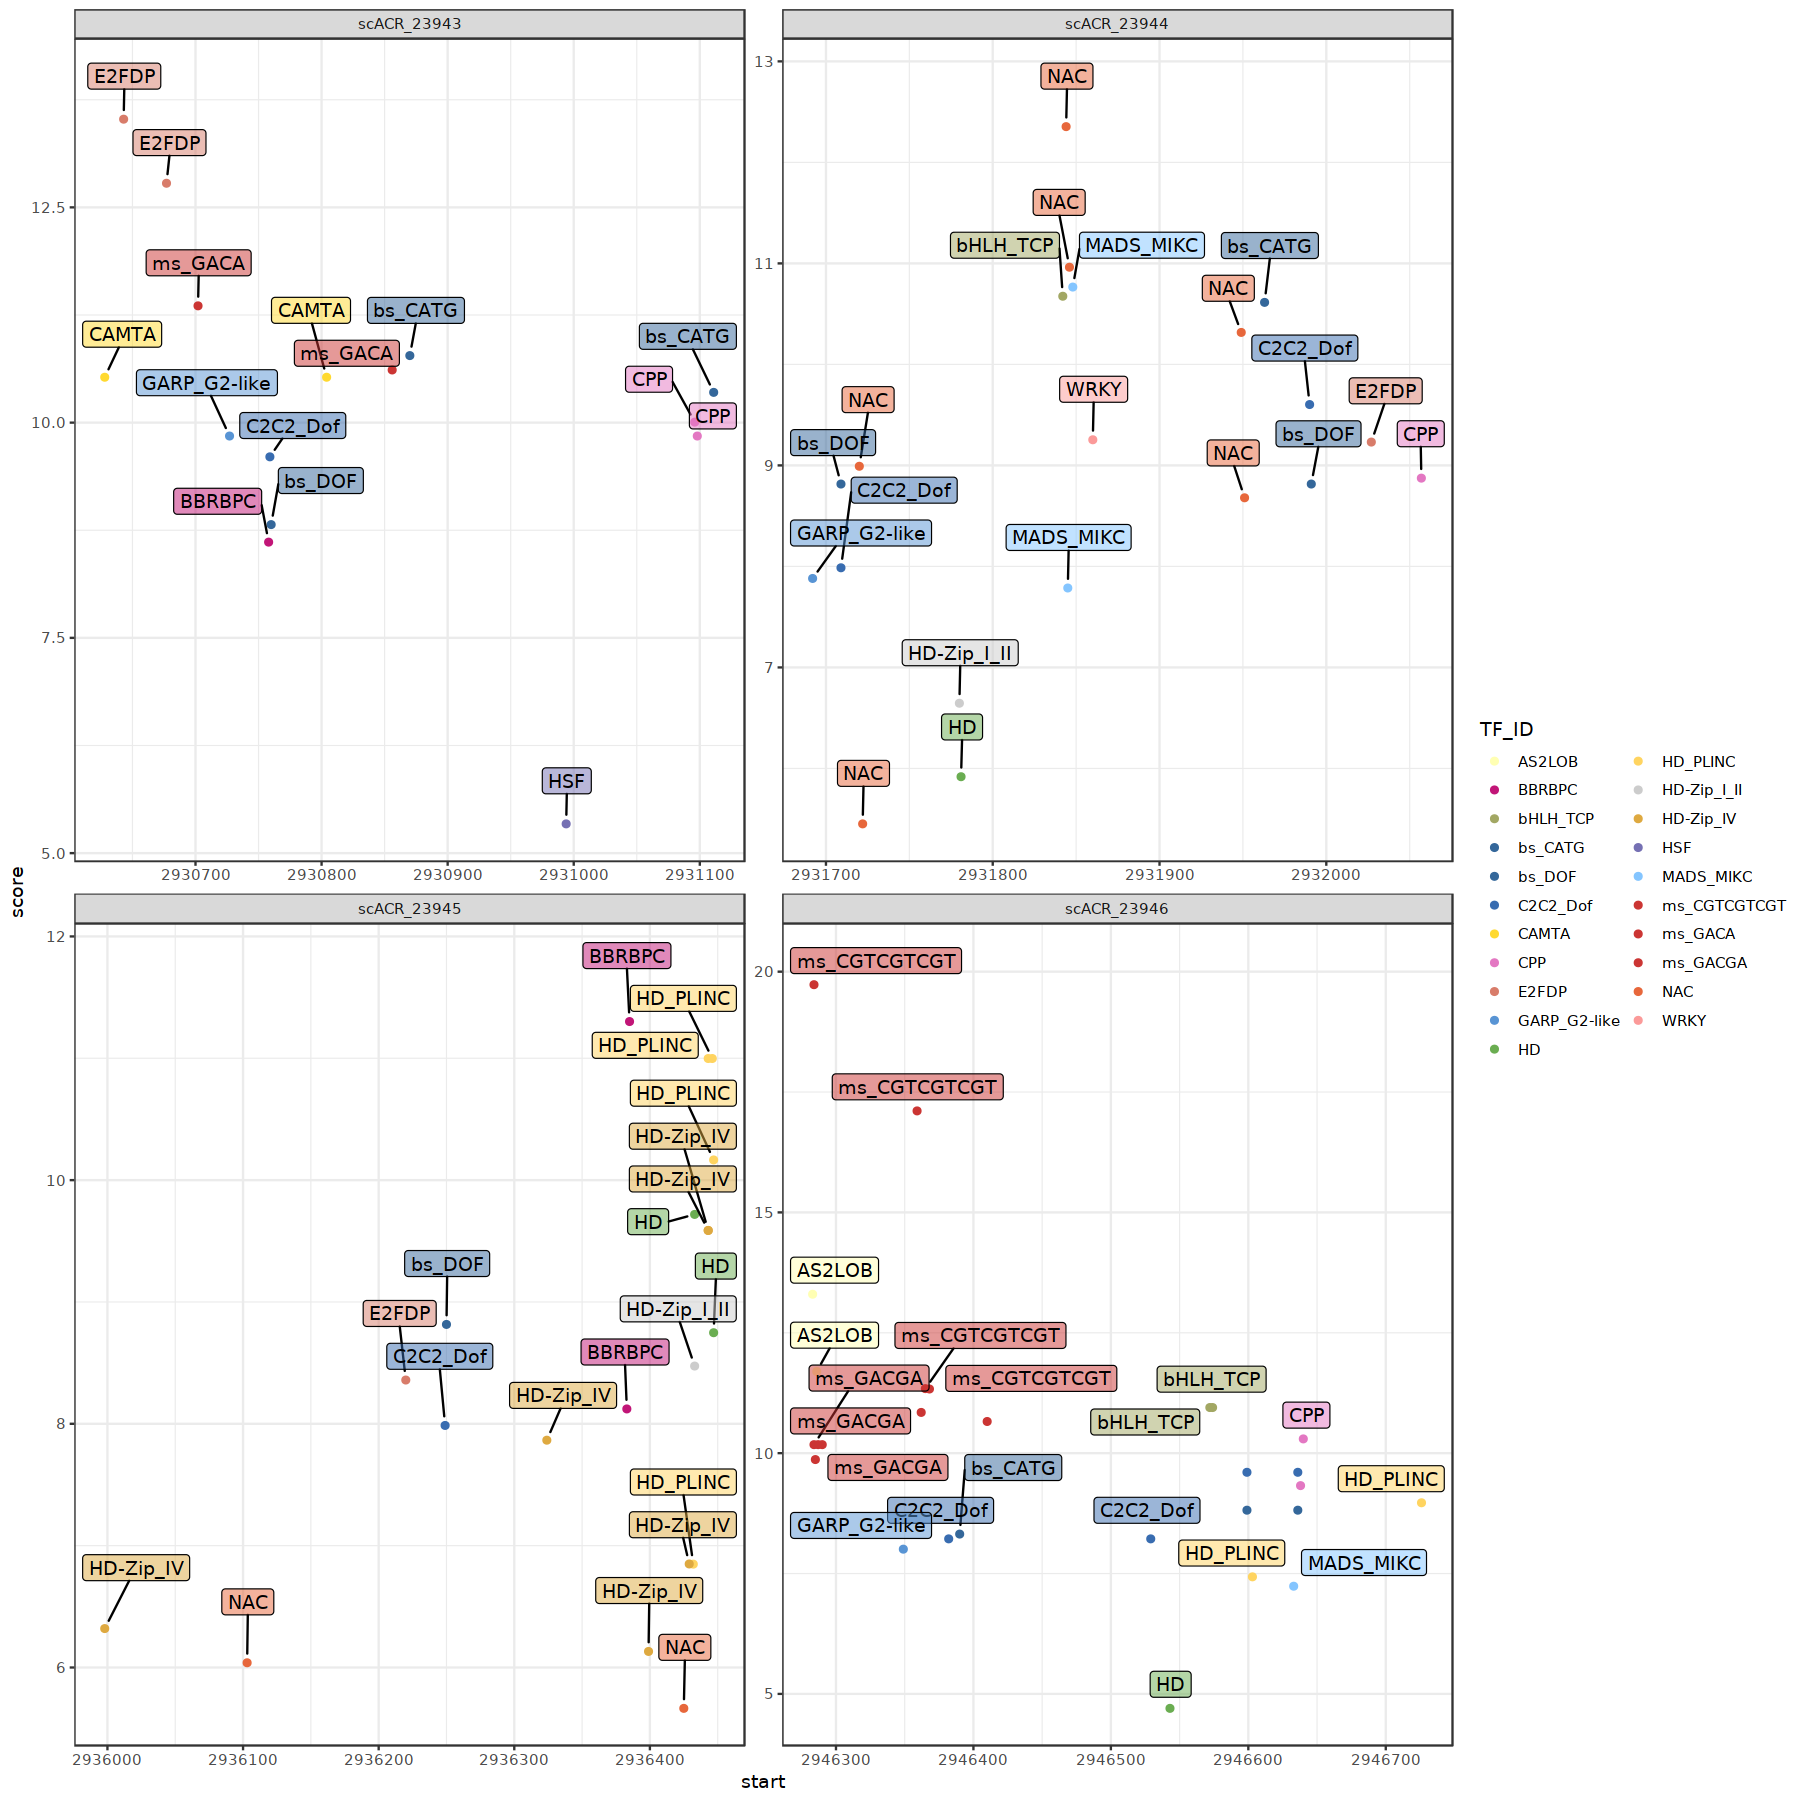

In [117]:
options(repr.plot.width=15, repr.plot.height=15)
### plotting_dit_2
dit_2_acrs <- final_data_frame %>% 
    filter(locus == "Sb__DIT_2")  

dit_2_acrs$color <- colored_characters[dit_2_acrs$TF_ID]
dit_2_acrs$color[is.na(dit_2_acrs$color)] <- "grey"

highlight_data_dit_2 <- zm_sb_blast_acr_scored_conservation %>%
  dplyr::mutate(id = acr) %>%
  dplyr::mutate(rStart = as.numeric(as.character(rStart)),
                rEnd = as.numeric(as.character(rEnd))) %>% 
    dplyr::filter(locus == "Sb__DIT_2") %>% 
    dplyr::filter(id %in% dit_2_acrs$id) %>% 
    dplyr::filter(acr == id)

sb_dit_2 <- ggplot(dit_2_acrs, aes(x = start, y = score, color = TF_ID)) +
    geom_point() +
    geom_label_repel(aes(label = TF_ID, color = "black", fill = TF_ID), 
                     nudge_x = 0.5, 
                     nudge_y = 0.5, 
                     max.overlaps = 5,
                     box.padding = 0.35, 
                     point.padding = 0.5,
                     hjust = 0.5, 
                     vjust = 0.5,
                     color = 'black', 
                     fill = alpha(dit_2_acrs$color, .5)) +
    scale_color_manual(values = colored_characters) +
    facet_wrap(~id, scales = "free") +
    theme_bw() +
    geom_rect(data = highlight_data_dit_2, inherit.aes = FALSE, 
              aes(xmin = rStart, xmax = rEnd, 
                  ymin = min(dit_2_acrs$score),
                  ymax = max(dit_2_acrs$score)), 
              color = "transparent", fill = "orange", alpha = 0.1) +
    guides(color = guide_legend(title = "TF_ID"))


sb_dit_2

ggsave(plot = sb_dit_2, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit2.motif_location.pdf",
      width = 18,
      height = 8)

Warning message:
“ggrepel: 9 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 5 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 3 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


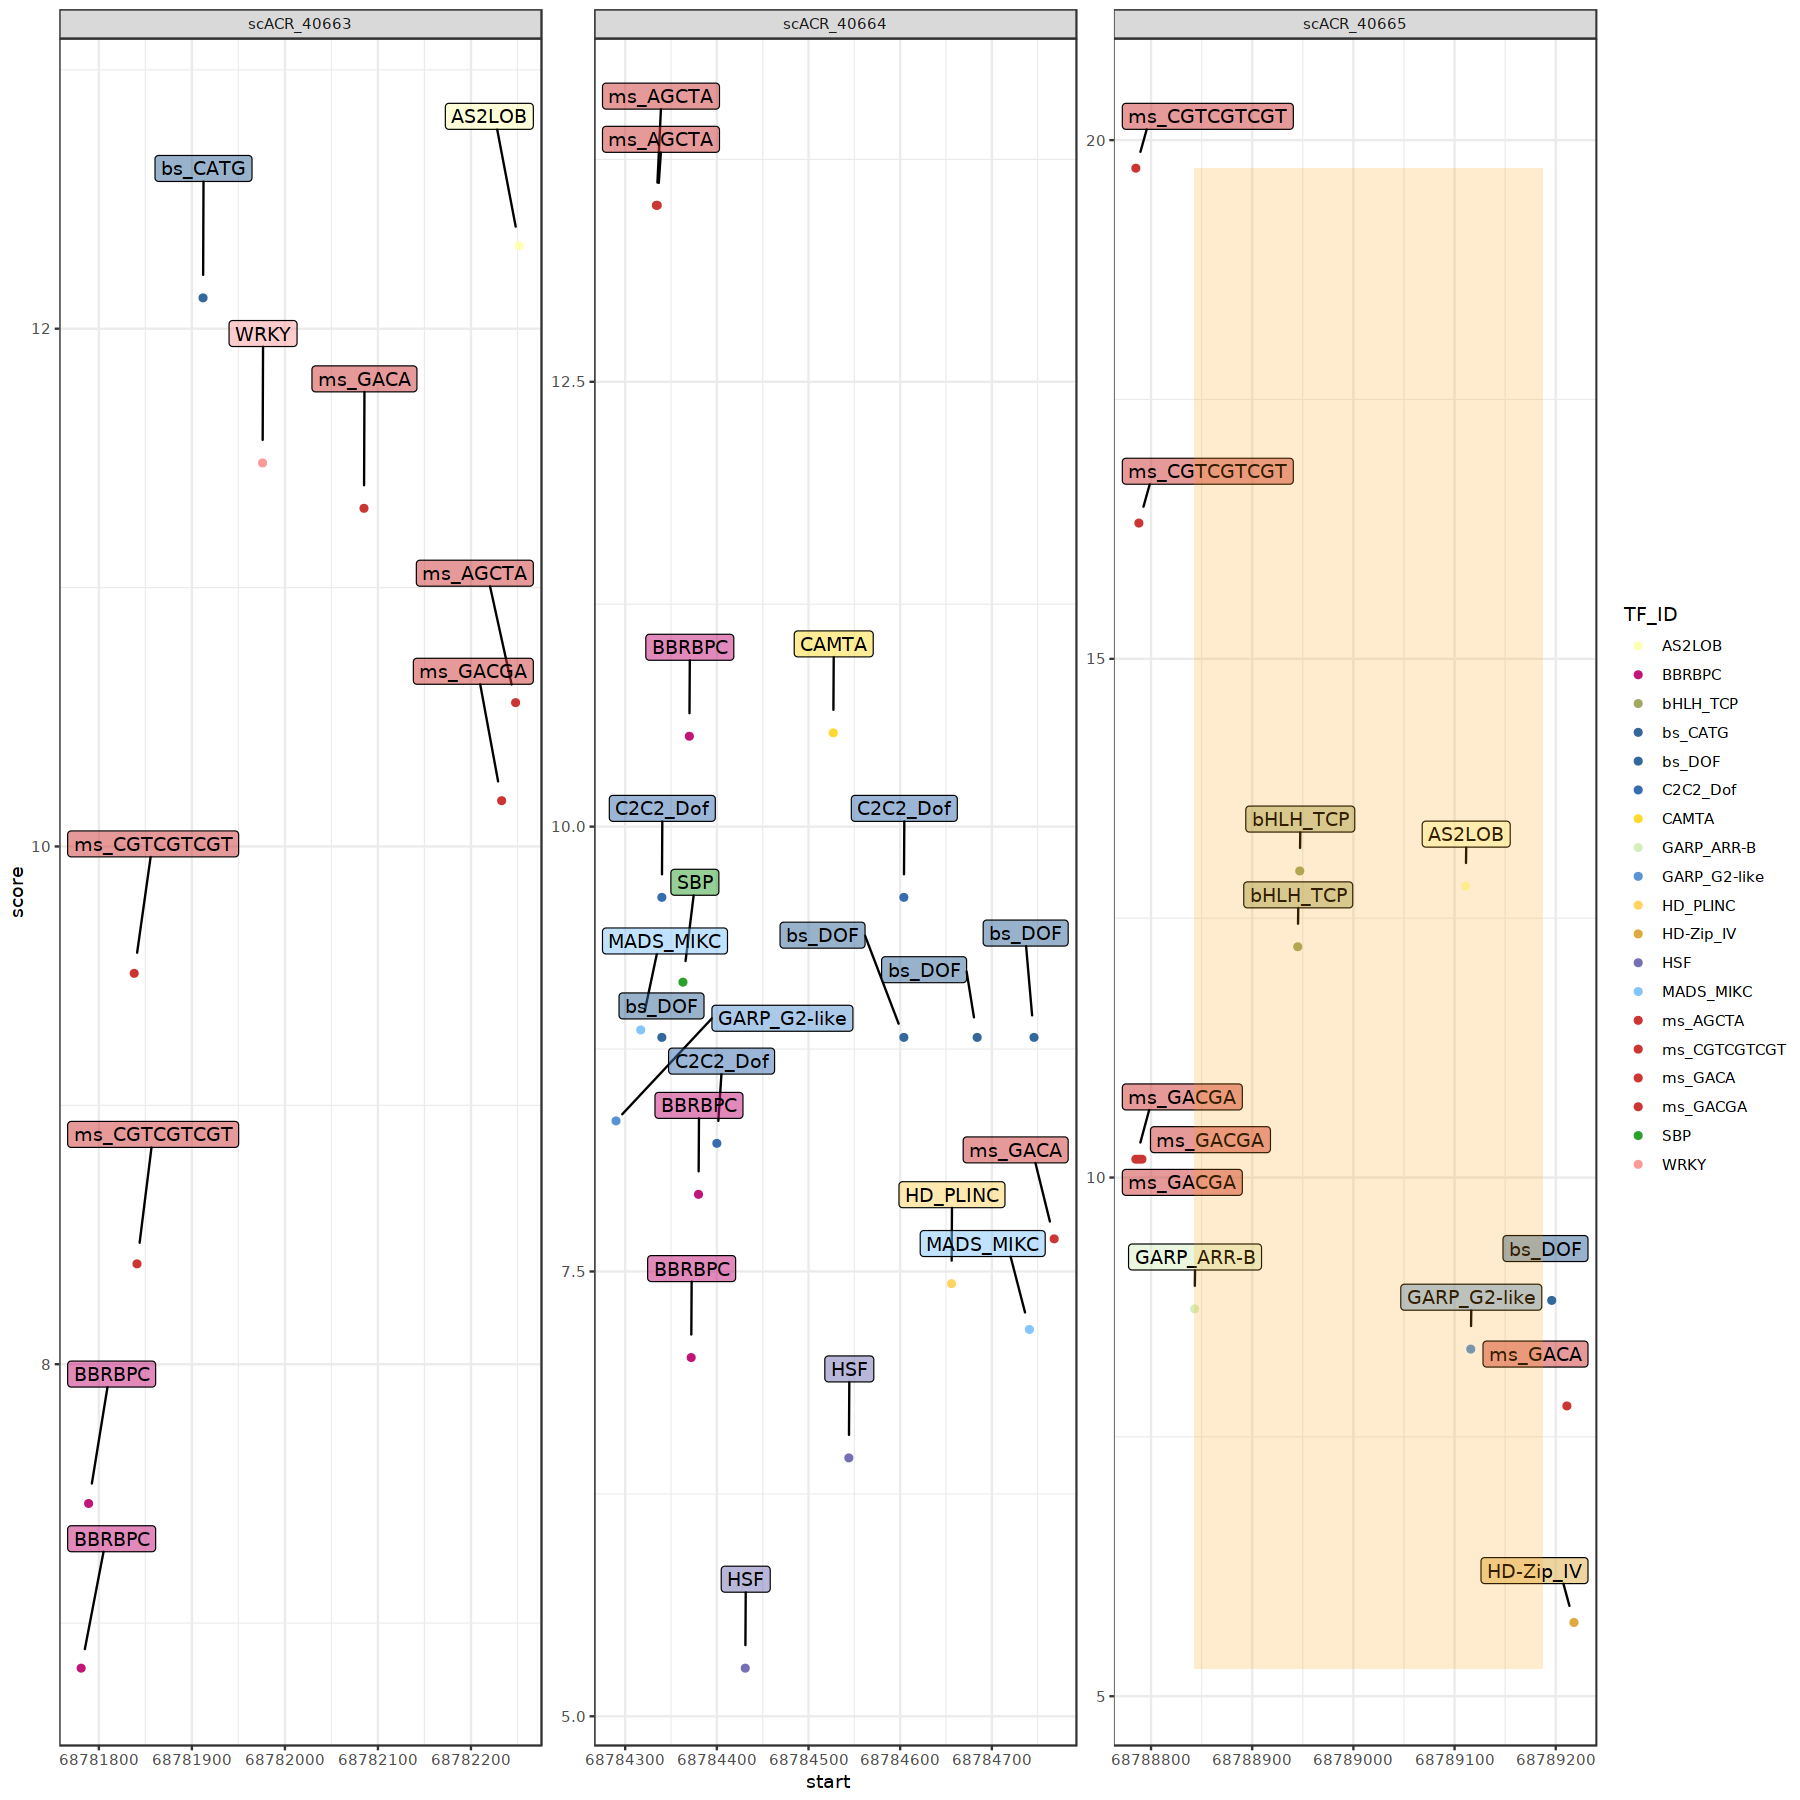

In [118]:
options(repr.plot.width=15, repr.plot.height=15)
### plotting_dit_3
dit_3_acrs <- final_data_frame %>% 
    filter(locus == "Sb__DIT_3")  

dit_3_acrs$color <- colored_characters[dit_3_acrs$TF_ID]
dit_3_acrs$color[is.na(dit_3_acrs$color)] <- "grey"


highlight_data_dit_3 <- zm_sb_blast_acr_scored_conservation %>%
  dplyr::mutate(id = acr) %>%
  dplyr::mutate(rStart = as.numeric(as.character(rStart)),
                rEnd = as.numeric(as.character(rEnd))) %>% 
    dplyr::filter(locus == "Sb__DIT_3") %>% 
    dplyr::filter(id %in% dit_3_acrs$id) %>% 
    dplyr::filter(acr == id)

sb_dit_3 <-  ggplot(dit_3_acrs, aes(x = start, y = score, color = TF_ID)) +
    geom_point() +
    geom_label_repel(aes(label = TF_ID, color = "black", fill = TF_ID), 
                     nudge_x = 0.5, 
                     nudge_y = 0.5, 
                     max.overlaps = 5,
                     box.padding = 0.35, 
                     point.padding = 0.5,
                     hjust = 0.5, 
                     vjust = 0.5,
                     color = 'black', 
                     fill = alpha(dit_3_acrs$color, .5)) +
    scale_color_manual(values = colored_characters) +
    facet_wrap(~id, scales = "free") +
    theme_bw() +
    geom_rect(data = highlight_data_dit_3, inherit.aes = FALSE, 
              aes(xmin = rStart, xmax = rEnd, 
                  ymin = min(dit_3_acrs$score),
                  ymax = max(dit_3_acrs$score)), 
              color = "transparent", fill = "orange", alpha = 0.1) +
    guides(color = guide_legend(title = "TF_ID"))

sb_dit_3
ggsave(plot = sb_dit_3, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit3.motif_location.pdf",
      width = 26,
      height = 4)

Warning message:
“ggrepel: 11 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Warning message:
“ggrepel: 15 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


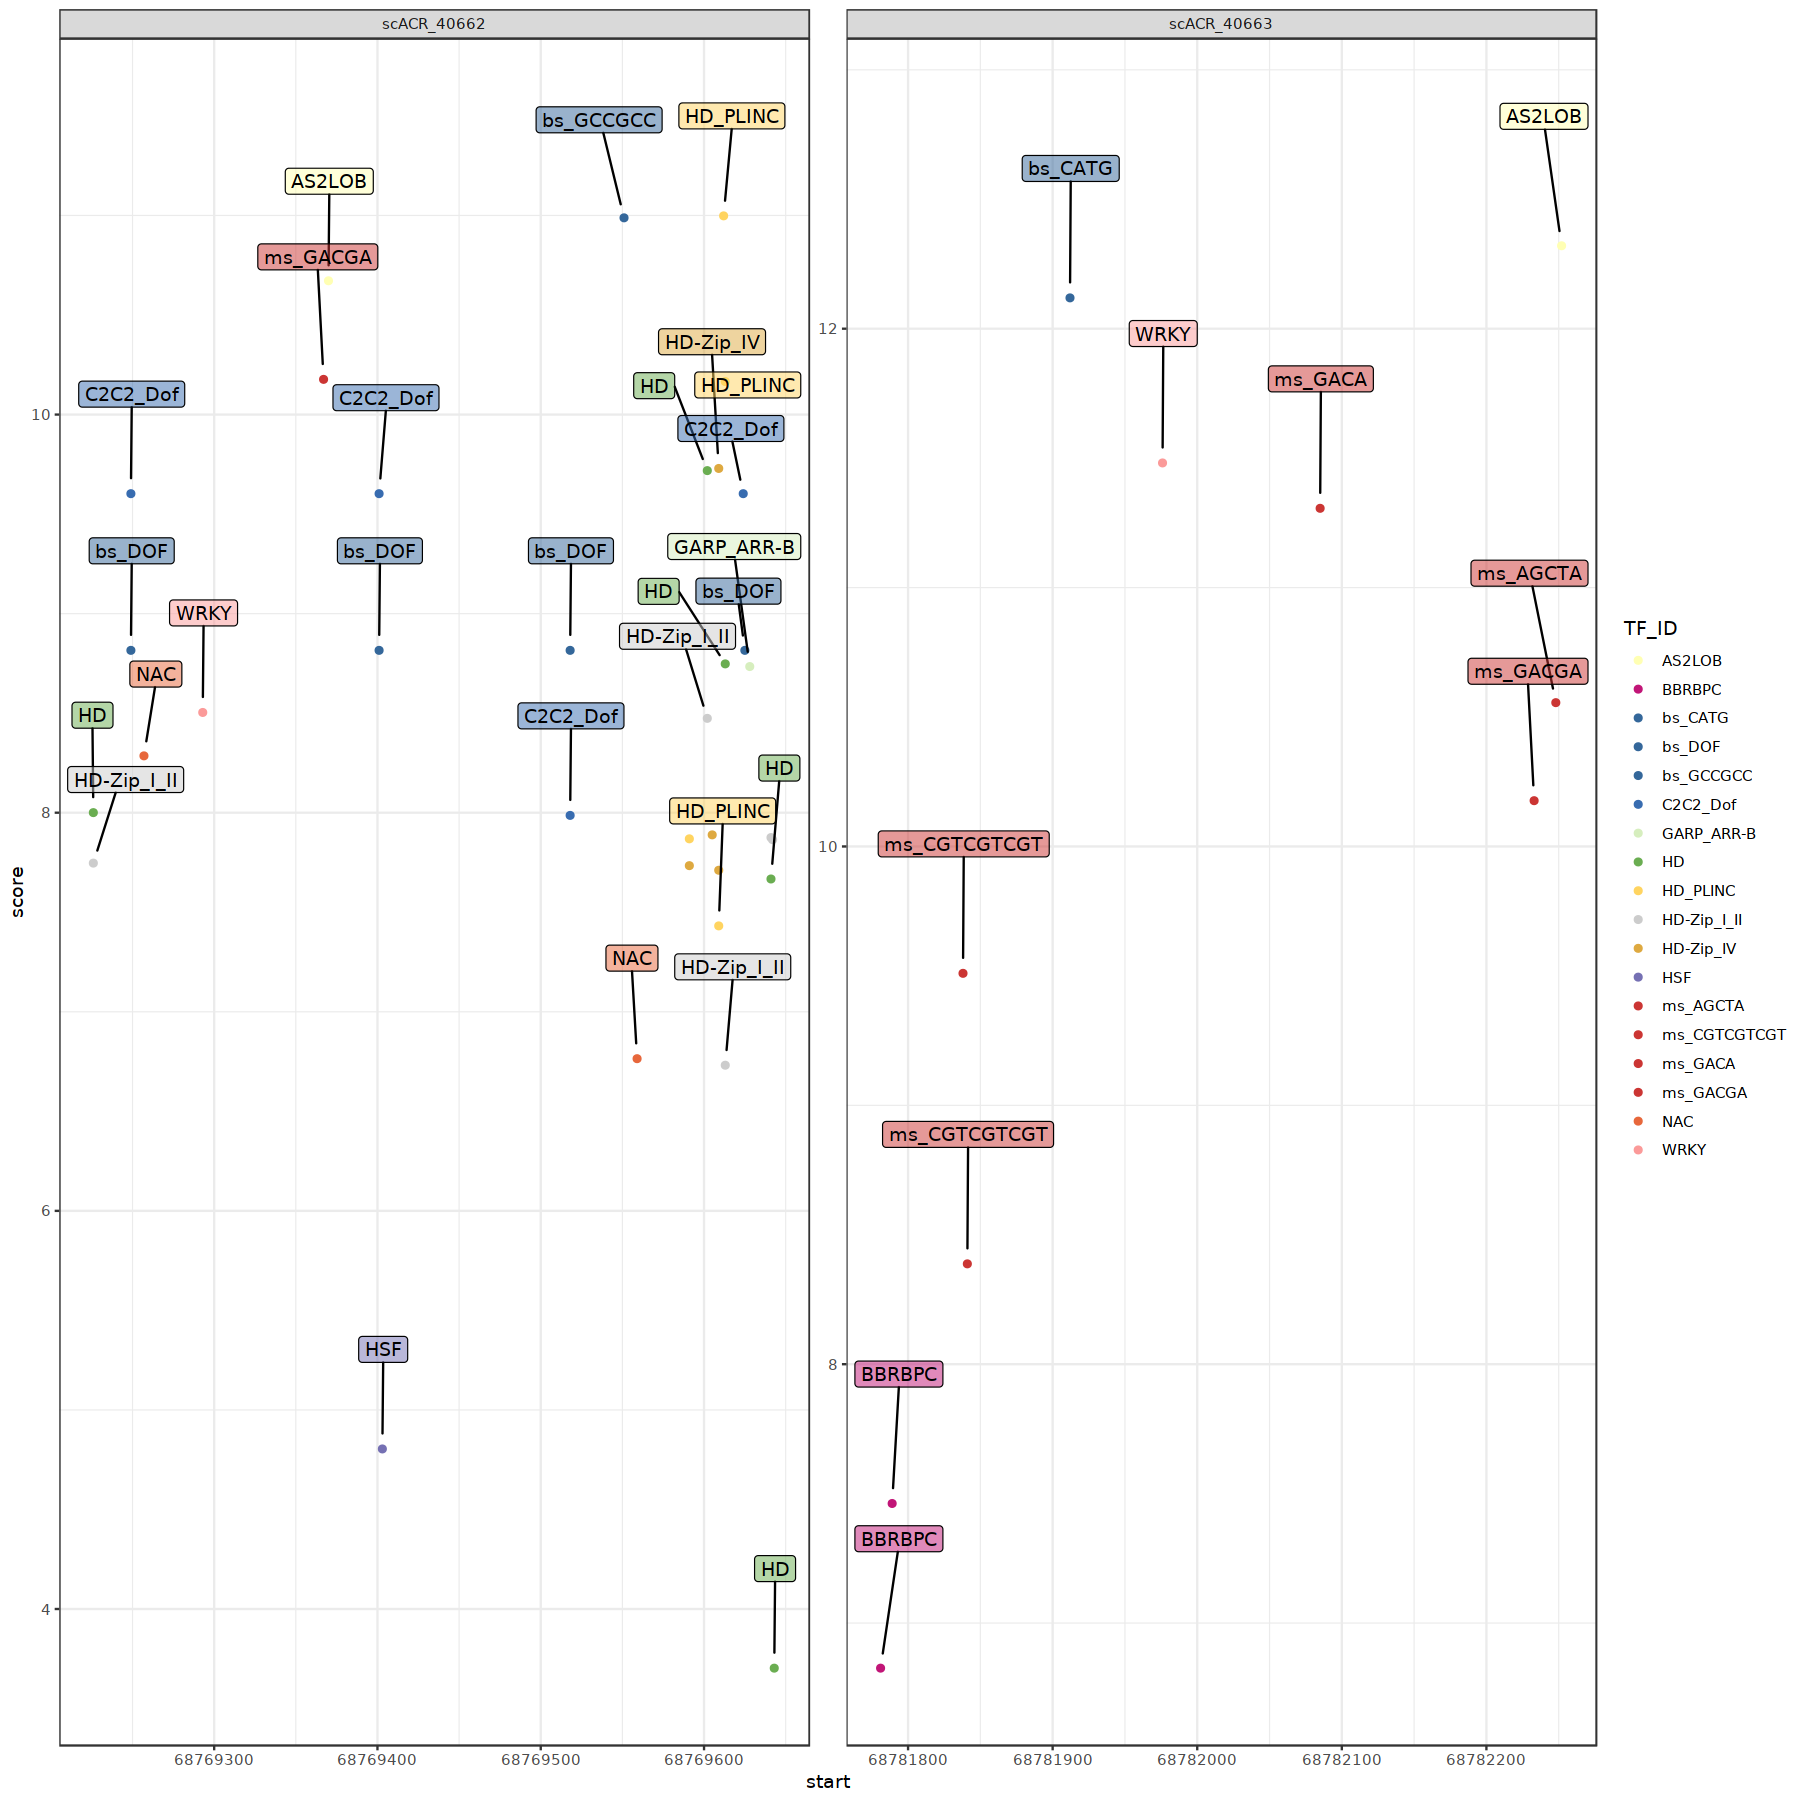

In [119]:
options(repr.plot.width=15, repr.plot.height=15)
### plotting_dit_4
dit_4_acrs <- final_data_frame %>% 
    filter(locus == "Sb__DIT_4")  

dit_4_acrs$color <- colored_characters[dit_4_acrs$TF_ID]
dit_4_acrs$color[is.na(dit_4_acrs$color)] <- "grey"

highlight_data_dit_4 <- zm_sb_blast_acr_scored_conservation %>%
  dplyr::mutate(id = acr) %>%
  dplyr::mutate(rStart = as.numeric(as.character(rStart)),
                rEnd = as.numeric(as.character(rEnd))) %>% 
    dplyr::filter(locus == "Sb__DIT_4") %>% 
    dplyr::filter(id %in% dit_4_acrs$id) %>% 
    dplyr::filter(acr == id)

sb_dit_4 <- ggplot(dit_4_acrs, aes(x = start, y = score, color = TF_ID)) +
    geom_point() +
    geom_label_repel(aes(label = TF_ID, color = "black", fill = TF_ID), 
                     nudge_x = 0.5, 
                     nudge_y = 0.5, 
                     max.overlaps = 5,
                     box.padding = 0.35, 
                     point.padding = 0.5,
                     hjust = 0.5, 
                     vjust = 0.5,
                     color = 'black', 
                     fill = alpha(dit_4_acrs$color, .5)) +
    scale_color_manual(values = colored_characters) +
    facet_wrap(~id, scales = "free") +
    theme_bw() +
    geom_rect(data = highlight_data_dit_4, inherit.aes = FALSE, 
              aes(xmin = rStart, xmax = rEnd, 
                  ymin = min(dit_4_acrs$score),
                  ymax = max(dit_4_acrs$score)), 
              color = "transparent", fill = "orange", alpha = 0.1) +
    guides(color = guide_legend(title = "TF_ID"))
sb_dit_4

ggsave(plot = sb_dit_4, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_locations/Sb.dit4.motif_location.pdf",
      width = 18,
      height = 4)

`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.
`summarise()` has grouped output by 'id'. You can override using the `.groups`
argument.


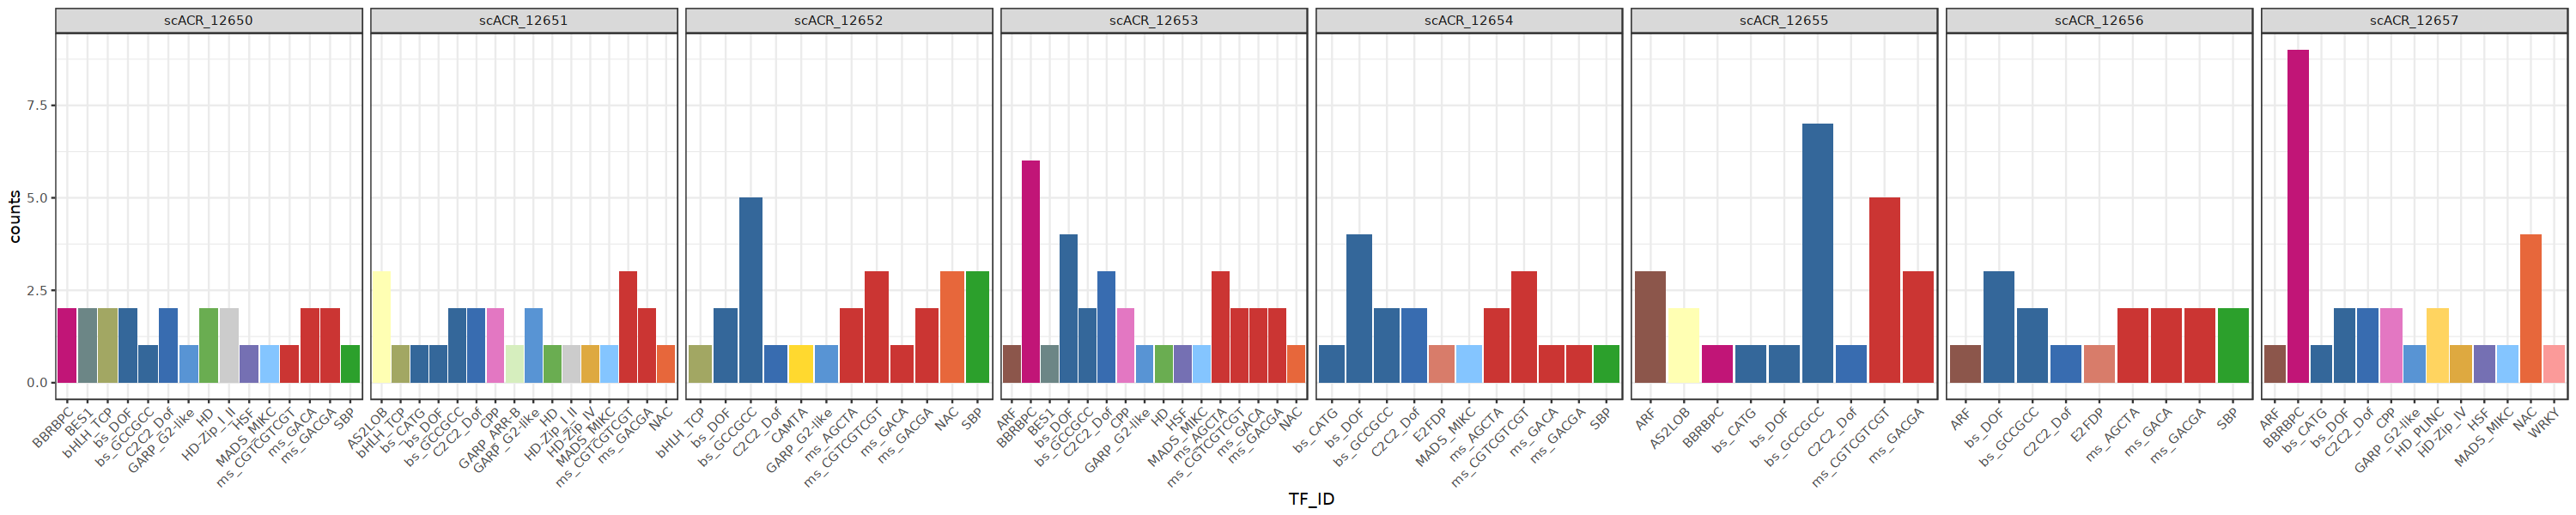

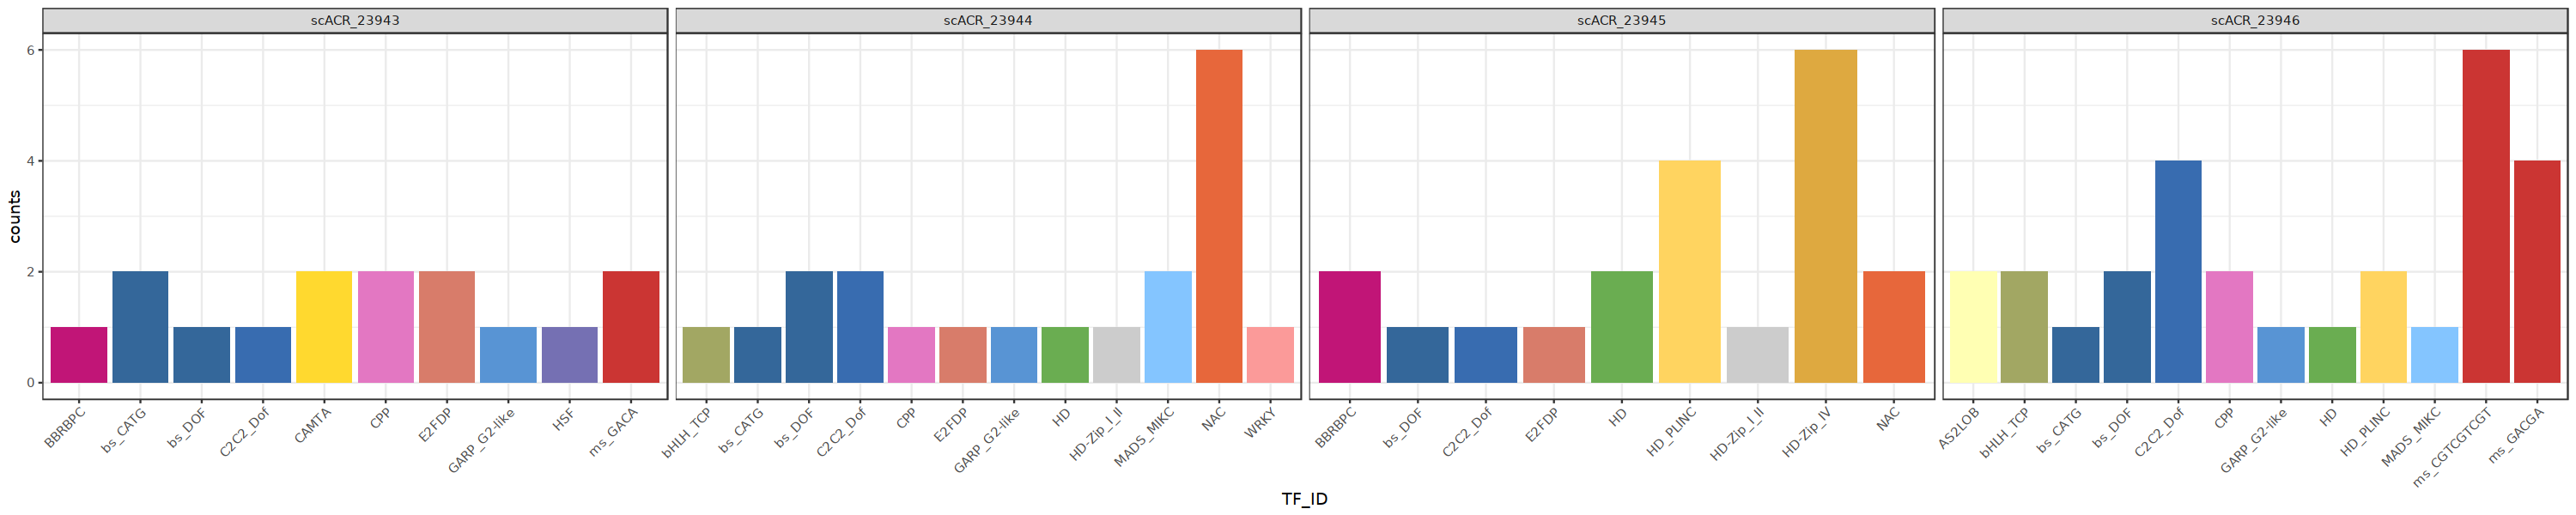

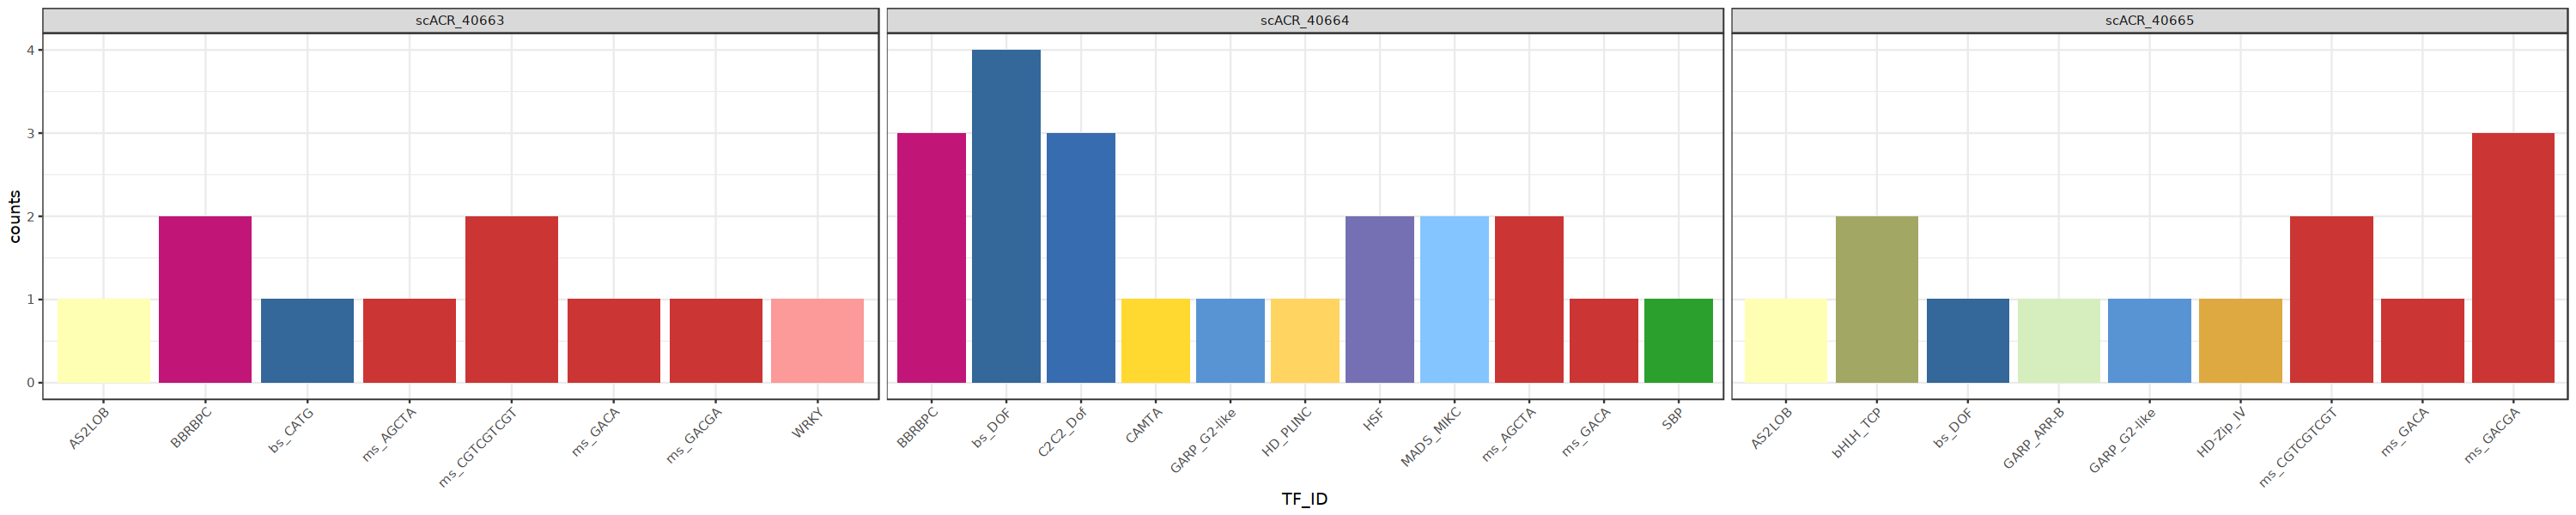

ERROR: [1m[33mError[39m in `ggsave()`:[22m
[1m[22m[33m![39m Dimensions exceed 50 inches (`height` and `width` are specified in
  [3minches[23m not pixels).
[36mℹ[39m If you're sure you want a plot that big, use `limitsize = FALSE`.


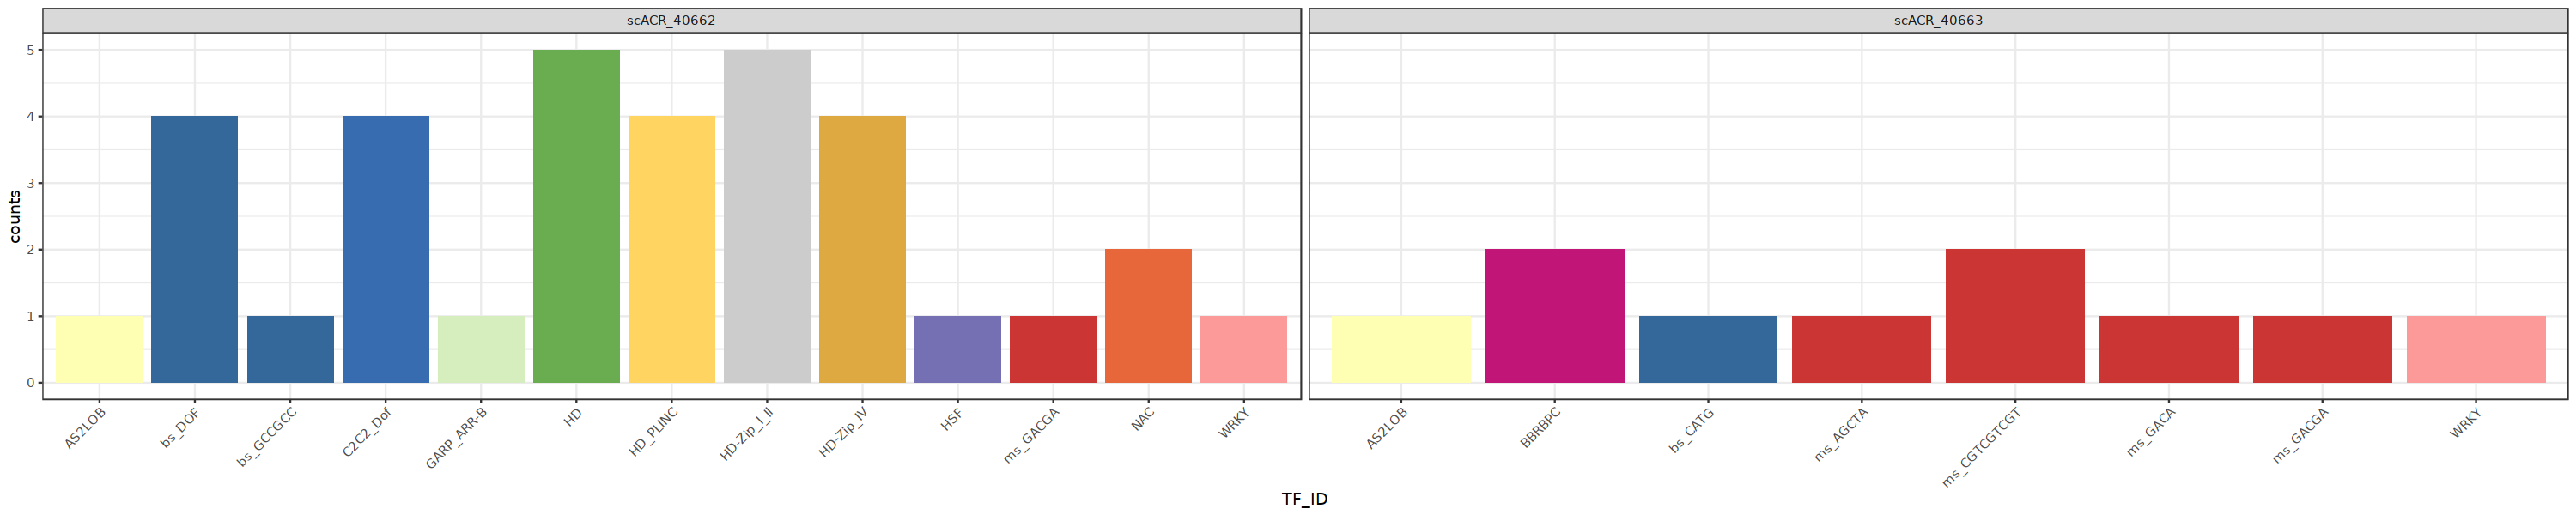

In [122]:
## Counting the Number of motifs PER ACR

dit_1_counts_motifs <- dit_1_acrs %>% 
    dplyr::group_by(id, TF_ID) %>% 
    dplyr::summarise(counts = n()) %>% 
    dplyr::ungroup()


dit_1_counts_motifs$color <- colored_characters[dit_1_counts_motifs$TF_ID]
dit_1_counts_motifs$color[is.na(dit_1_counts_motifs$color)] <- "grey"

options(repr.plot.width=25, repr.plot.height=5)

dit_1_motif_counts_acrs <- ggplot(dit_1_counts_motifs, aes(x = TF_ID, y = counts)) +
 geom_col(aes(fill = color)) + # Here we use 'fill' aesthetic mapped to 'color' column
  facet_grid(~ id, scales = "free") +
  scale_fill_identity() + # Use the actual colors specified in 'color' column
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis text to 45 degrees

## Counting the Number of motifs PER ACR
dit_2_counts_motifs <- dit_2_acrs %>% 
    dplyr::group_by(id, TF_ID) %>% 
    dplyr::summarise(counts = n()) %>% 
    dplyr::ungroup()


dit_2_counts_motifs$color <- colored_characters[dit_2_counts_motifs$TF_ID]
dit_2_counts_motifs$color[is.na(dit_2_counts_motifs$color)] <- "grey"

options(repr.plot.width=25, repr.plot.height=5)
dit_2_motif_counts_acrs <- ggplot(dit_2_counts_motifs, aes(x = TF_ID, y = counts)) +
 geom_col(aes(fill = color)) + # Here we use 'fill' aesthetic mapped to 'color' column
  facet_grid(~ id, scales = "free") +
  scale_fill_identity() + # Use the actual colors specified in 'color' column
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1)) # Rotate x-axis text to 45 degrees


# Code for dit_3_counts_motifs
dit_3_counts_motifs <- dit_3_acrs %>% 
  group_by(id, TF_ID) %>% 
  summarise(counts = n(), .groups = 'drop') %>% 
  ungroup()

dit_3_counts_motifs$color <- colored_characters[dit_3_counts_motifs$TF_ID]
dit_3_counts_motifs$color[is.na(dit_3_counts_motifs$color)] <- "grey"

# Code for dit_4_counts_motifs
dit_4_counts_motifs <- dit_4_acrs %>% 
  group_by(id, TF_ID) %>% 
  summarise(counts = n(), .groups = 'drop') %>% 
  ungroup()

dit_4_counts_motifs$color <- colored_characters[dit_4_counts_motifs$TF_ID]
dit_4_counts_motifs$color[is.na(dit_4_counts_motifs$color)] <- "grey"


# ggplot for dit_3
dit_3_motif_counts_acrs <- ggplot(dit_3_counts_motifs, aes(x = TF_ID, y = counts, fill = color)) +
  geom_col() + 
  facet_grid(~ id, scales = "free") +
  scale_fill_identity() + 
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

# ggplot for dit_4
dit_4_motif_counts_acrs <- ggplot(dit_4_counts_motifs, aes(x = TF_ID, y = counts, fill = color)) +
  geom_col() + 
  facet_grid(~ id, scales = "free") +
  scale_fill_identity() + 
  theme_bw() +
  theme(axis.text.x = element_text(angle = 45, hjust = 1))

dit_1_motif_counts_acrs
dit_2_motif_counts_acrs
dit_3_motif_counts_acrs
dit_4_motif_counts_acrs

ggsave(plot = dit_1_motif_counts_acrs, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_counts/Sb.dit1.motif_count.pdf",
      width = 64,
      height = 4)

ggsave(plot = dit_2_motif_counts_acrs, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_counts/Sb.dit2.motif_count.pdf",
      width = 32,
      height = 4)

ggsave(plot = dit_3_motif_counts_acrs, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_counts/Sb.dit3.motif_count.pdf",
      width = 24,
      height = 4)

ggsave(plot = dit_4_motif_counts_acrs, 
       filename = "/home/jpm73279/data_copy_over/comparative_single_cell_imgs/figures/figure_7/motif_counts/Sb.dit4.motif_count.pdf",
      width = 16,
      height = 4)

In [ ]:
acr_count <- filterd_DITs %>% 
    dplyr::select(locus, acr) %>% 
    group_by(locus) %>% 
    summarise(n_acrs = n())

Warning message:
“Returning more (or less) than 1 row per `summarise()` group was deprecated in
dplyr 1.1.0.
ℹ Please use `reframe()` instead.
ℹ When switching from `summarise()` to `reframe()`, remember that `reframe()`
  always returns an ungrouped data frame and adjust accordingly.”
`summarise()` has grouped output by 'locus', 'TF_ID', 'n_acrs'. You can
override using the `.groups` argument.


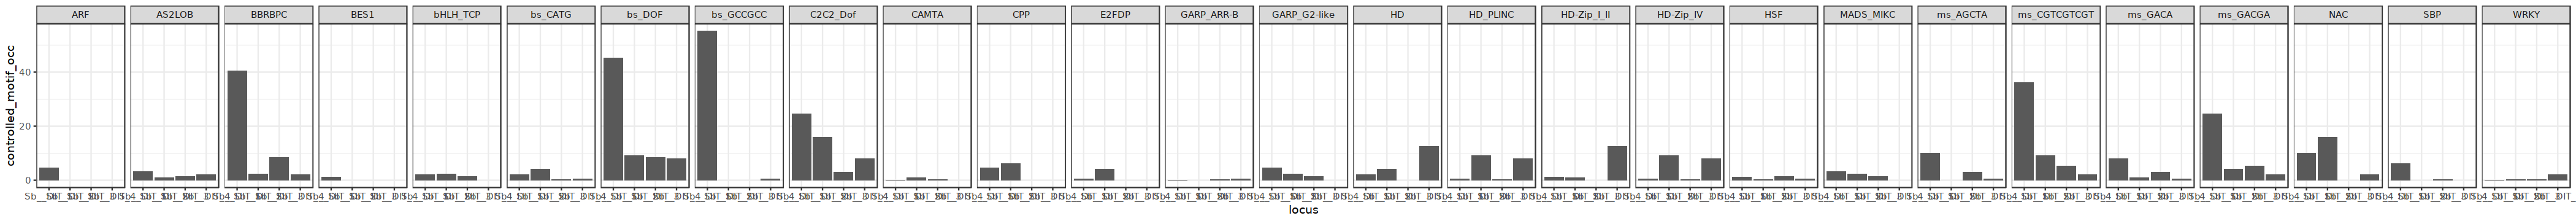

In [55]:
options(repr.plot.width=35, repr.plot.height=3)
final_data_frame %>% 
    left_join(.,acr_count , by = "locus") %>% 
    dplyr::group_by(locus, TF_ID, n_acrs) %>% 
    dplyr::summarise(total_motif_occurence = n(),
                    controlled_motif_occ  = total_motif_occurence/n_acrs) %>% 
    ggplot(., aes(x = locus, y = controlled_motif_occ)) + 
    geom_bar(stat="identity") + 
    facet_grid(. ~ TF_ID) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    theme_bw()


In [70]:
head(final_data_frame)

,group,group_name,seqnames,start,end,width,strand,score,TF_ID,id,⋯,gene_family,number,X6,X7,X8,acr_cell_type_specific_class,X10,species,geneID,enzyme_location
,<int>,<chr>,<fct>,<int>,<int>,<int>,<fct>,<dbl>,<chr>,<chr>,⋯,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>,<chr>
1,1,NA,Chr02,63774753,63774758,6,+,9.076553,ARF,scACR_12653,⋯,DIT,1,Chr02,63774378,63774879,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
2,1,NA,Chr02,63778091,63778096,6,-,10.022463,ARF,scACR_12655,⋯,DIT,1,Chr02,63777963,63778464,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
3,1,NA,Chr02,63778223,63778228,6,-,9.076553,ARF,scACR_12655,⋯,DIT,1,Chr02,63777963,63778464,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
4,1,NA,Chr02,63778255,63778260,6,-,9.076553,ARF,scACR_12655,⋯,DIT,1,Chr02,63777963,63778464,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
5,1,NA,Chr02,63780672,63780677,6,+,9.076553,ARF,scACR_12656,⋯,DIT,1,Chr02,63780210,63780711,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll
6,1,NA,Chr02,63781329,63781334,6,+,9.076553,ARF,scACR_12657,⋯,DIT,1,Chr02,63781238,63781739,broadly_accessible,NA,Sb,Sobic.002G233700,mesophyll


`summarise()` has grouped output by 'id', 'locus'. You can override using the
`.groups` argument.


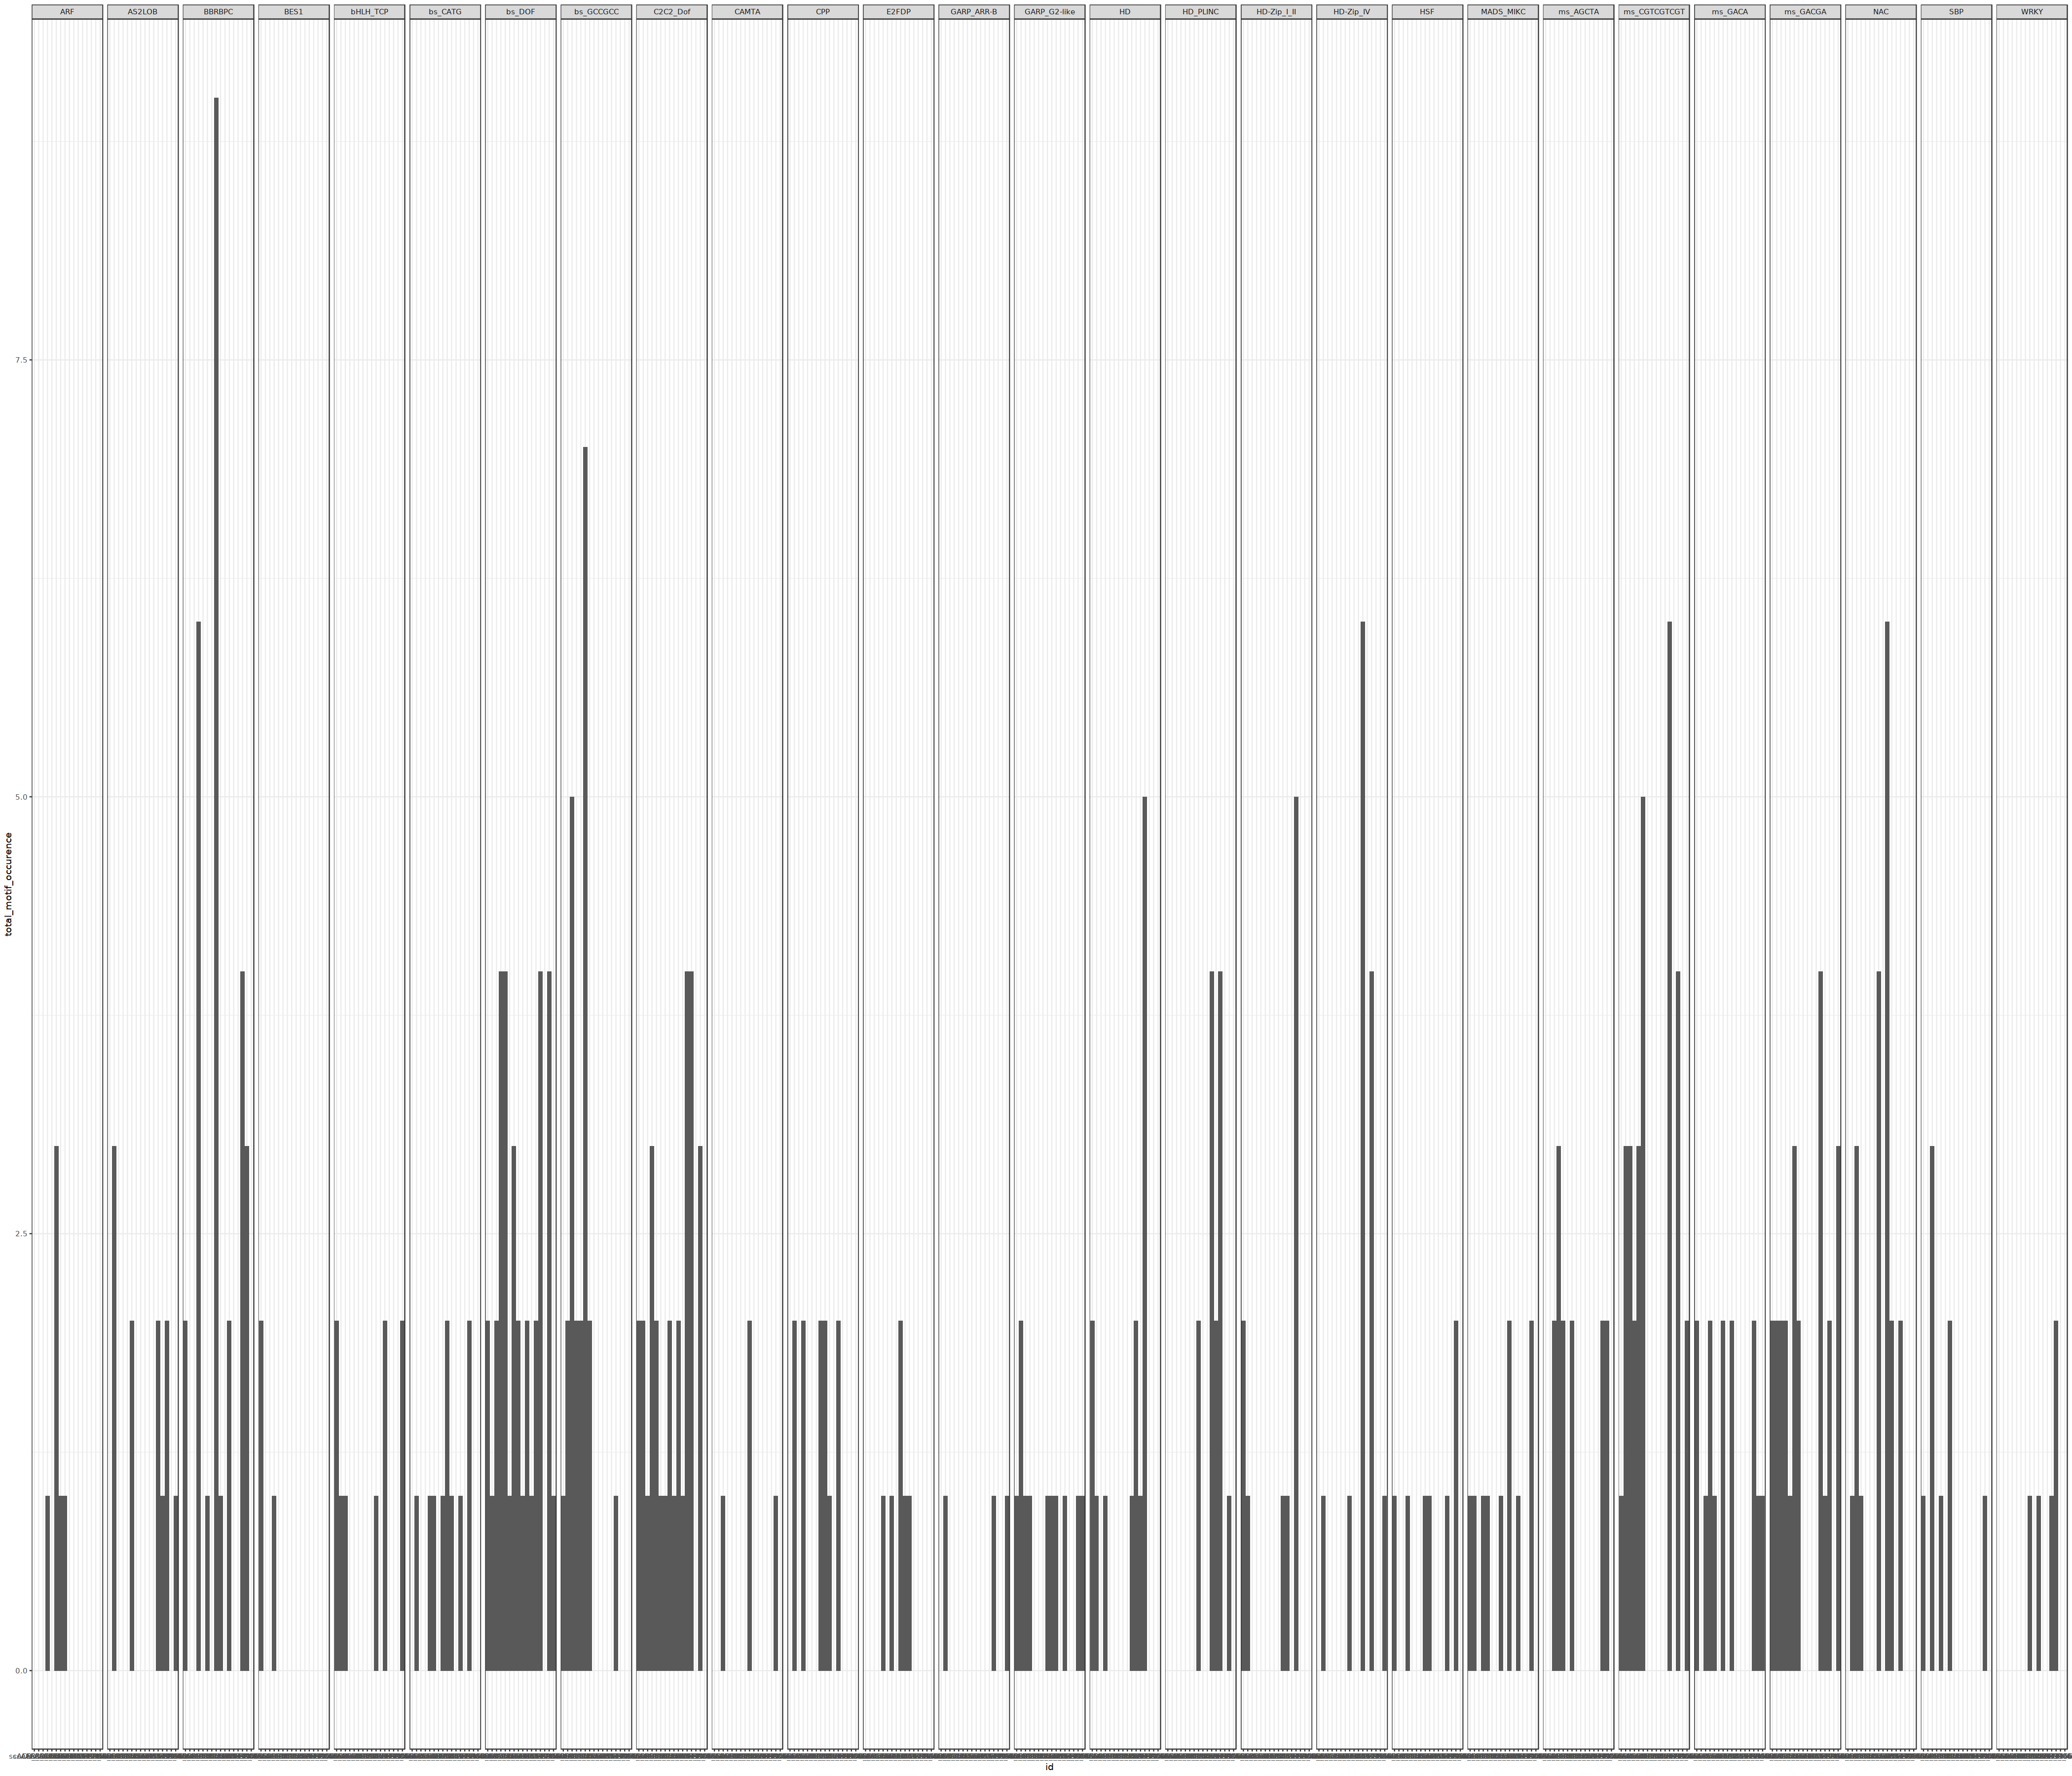

In [79]:
options(repr.plot.width=35, repr.plot.height=30)
final_data_frame %>% 
    dplyr::group_by(id, locus, TF_ID) %>% 
    dplyr::summarise(total_motif_occurence = n()) %>% 
    ggplot(., aes(x = id, y = total_motif_occurence)) + 
    geom_bar(stat="identity") + 
    facet_grid(. ~ TF_ID) +
    theme(axis.text.x = element_text(angle = 90, vjust = 0.5, hjust=1)) + 
    theme_bw()
